In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
df = pd.read_csv("BERT/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
round(747/4825,4)

0.1548

In [6]:
df_spam = df[df["Category"]=="spam"]
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df["Category"]=="ham"]
df_ham.shape

(4825, 2)

In [8]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced["Category"].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [11]:
df_balanced.sample(5)

,Category,Message
3393,ham,What r u cooking me for dinner?
251,ham,Ranjith cal drpd Deeraj and deepak 5min hold
5447,ham,So that takes away some money worries
1499,ham,Time n Smile r the two crucial things in our l...
900,spam,Your free ringtone is waiting to be collected....


In [12]:
df_balanced["Spam"] = df_balanced["Category"].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,Spam
4860,ham,"Hey, a guy I know is breathing down my neck to...",0
4042,spam,Please call our customer service representativ...,1
2992,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,1
2163,ham,1) Go to write msg 2) Put on Dictionary mode 3...,0
3463,spam,Bloomberg -Message center +447797706009 Why wa...,1
4235,ham,Now only i reached home. . . I am very tired n...,0
1386,ham,That's ok. I popped in to ask bout something a...,0
4903,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...,1
2160,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...,1
4053,ham,"Ya ok, then had dinner?",0


In [13]:
X = df_balanced["Message"]
y = df_balanced["Spam"]

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df_balanced["Spam"])

In [15]:
X_train.head()

1663    Hi if ur lookin 4 saucy daytime fun wiv busty ...
3927                           I havent add ü yet right..
2924                              Fine am simply sitting.
2209    URGENT!! Your 4* Costa Del Sol Holiday or £500...
2536    Can you pls pls send me a mail on all you know...
Name: Message, dtype: object

In [22]:
X_train.shape

(1120,)

## BERT

In [16]:
preprocess_url = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"
encoder_url = "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4"

In [17]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

### Sentence Embedding Function

In [24]:
 def get_sentence_embedding(input_text):
     proprocessed_output = bert_preprocess(input_text)
     encoded_text = bert_encoder(proprocessed_output)
     return encoded_text['pooled_output']

In [25]:
sample = [
    "banana",
    "grape",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]

In [29]:
sample_output = get_sentence_embedding(sample)
sample_output

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606918 , -0.1421939 ,  0.49604574, ...,  0.42165288,
        -0.5322141 ,  0.8031218 ],
       [-0.854085  , -0.17408381,  0.23000923, ...,  0.22893827,
        -0.55810875,  0.8516548 ],
       [-0.7128861 , -0.154639  ,  0.38401738, ...,  0.35278767,
        -0.50991327,  0.734741  ],
       [-0.82533467, -0.35550553, -0.5906963 , ..., -0.01613665,
        -0.61417556,  0.872303  ],
       [-0.7504136 , -0.2681262 , -0.26689762, ...,  0.0283935 ,
        -0.59380996,  0.7974989 ],
       [-0.78544384, -0.29949707,  0.4102738 , ...,  0.5222538 ,
        -0.49573562,  0.81507534]], dtype=float32)>

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([sample_output[0]],[sample_output[1]])

array([[0.9718795]], dtype=float32)

#### Here 
- sample_output[0] = banana
- sample_output[1] = grape
#### *Similarity between them is 97.19%*

In [36]:
cosine_similarity([sample_output[0]],[sample_output[3]])

array([[0.8470387]], dtype=float32)

In [40]:
cosine_similarity([sample_output[3]],[sample_output[4]])

array([[0.98720354]], dtype=float32)

 ### Let's get into Spam message classification

In [45]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
output = tf.keras.layers.Dropout(0.1, name="dropout")(outputs["pooled_output"])
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(output)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[output])

In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [49]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=METRICS)

In [50]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 109s 3s/step - loss: 0.6486 - accuracy: 0.6205 - precision: 0.6208 - recall: 0.6196
Epoch 2/10
35/35 [==============================] - 103s 3s/step - loss: 0.5171 - accuracy: 0.8018 - precision: 0.7934 - recall: 0.8161
Epoch 3/10
35/35 [==============================] - 102s 3s/step - loss: 0.4401 - accuracy: 0.8625 - precision: 0.8537 - recall: 0.8750
Epoch 4/10
35/35 [==============================] - 103s 3s/step - loss: 0.3971 - accuracy: 0.8795 - precision: 0.8722 - recall: 0.8893
Epoch 5/10
35/35 [==============================] - 102s 3s/step - loss: 0.3647 - accuracy: 0.8884 - precision: 0.8796 - recall: 0.9000
Epoch 6/10
35/35 [==============================] - 99s 3s/step - loss: 0.3386 - accuracy: 0.9018 - precision: 0.8947 - recall: 0.9107
Epoch 7/10
35/35 [==============================] - 100s 3s/step - loss: 0.3247 - accuracy: 0.9036 - precision: 0.8951 - recall: 0.9143
Epoch 8/10
35/35 [==============================]

In [51]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 34s 3s/step - loss: 0.2735 - accuracy: 0.9037 - precision: 0.8995 - recall: 0.9091


[0.27353930473327637,
 0.903743326663971,
 0.8994709253311157,
 0.9090909361839294]

In [52]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 34s 3s/step


In [54]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[168,  19],
       [ 17, 170]], dtype=int64)

Text(50.722222222222214, 0.5, 'True')

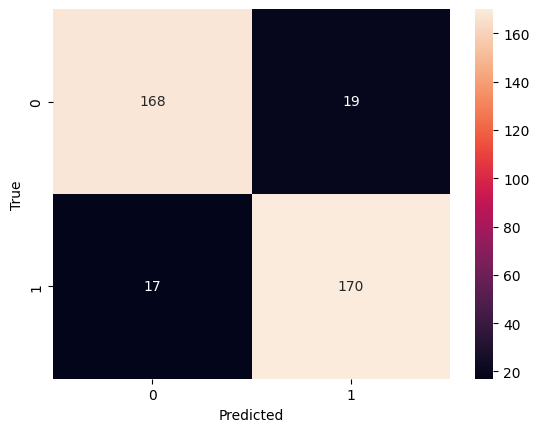

In [56]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [57]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       187
           1       0.90      0.91      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



### Inference

In [68]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until March 31, 2025',
    'Hey Niloy, are coming for the interview tomorrow',
    'Congratulations Niloy Sannyal, You are selected for the job post AI Engineer. You can join from Tomorrow. Address: House 17, Road 5, Gulshan 2, Dhaka',
    'You are awarded a Sony Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    "Why don't you wait 'til at least wednesday to see if you get your.",
]

In [69]:
model.predict(reviews)

1/1 [==============================] - 0s 439ms/step


array([[0.7792678 ],
       [0.18783836],
       [0.8207181 ],
       [0.85163784],
       [0.11205456]], dtype=float32)